
## **1. Introduzione Tecnica: Il Motore sotto il Cofano**

Molti praticanti usano XGBoost come una "black box", ma l'efficacia del tuning dipende dalla comprensione di due pilastri: l'approccio matematico di **secondo ordine** e l'**ottimizzazione di sistema**.

### **1.1 Oltre il classico Gradient Boosting (GBM)**

Il Gradient Boosting standard è un metodo "additivo". Invece di ottimizzare i parametri di un singolo modello complesso (come in una rete neurale), costruiamo un insieme di modelli "deboli" (alberi decisionali) in sequenza.

Matematicamente, la predizione al passo $t$ per l'istanza $i$ è data da:

$$\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta f_t(x_i)$$

Dove:
* $\hat{y}_i^{(t-1)}$ è la predizione accumulata fino al passo precedente.
* $f_t(x_i)$ è il nuovo albero che stiamo aggiungendo.
* $\eta$ è il learning rate.



**La differenza cruciale:**
In un GBM standard, il nuovo albero $f_t$ viene addestrato per predire i **residui** (o il gradiente negativo della loss) del modello precedente. Usa il metodo della *Discesa del Gradiente* (Primo Ordine).

**XGBoost**, invece, utilizza il **Metodo di Newton** (Secondo Ordine). Quando ottimizza la funzione obiettivo per trovare il miglior albero successivo, non guarda solo la pendenza (gradiente), ma anche la **curvatura** della funzione di loss.

### **1.2 L'Espansione di Taylor: Il cuore di XGBoost**

Per capire i parametri che vedremo dopo (come `min_child_weight`), dobbiamo guardare l'approssimazione della Loss Function che XGBoost utilizza.

XGBoost approssima la funzione obiettivo usando l'**Espansione di Taylor di secondo ordine**:

$$\mathcal{L}^{(t)} \approx \sum_{i=1}^n \left[ l(y_i, \hat{y}^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2}h_i f_t^2(x_i) \right] + \Omega(f_t)$$

Qui risiedono i due concetti più importanti per un utente avanzato:

1.  **$g_i$ (Gradiente):** La derivata prima (la direzione verso cui muoversi).
2.  **$h_i$ (Hessiana):** La derivata seconda (la curvatura). Rappresenta quanto siamo "sicuri" o quanto rapidamente sta cambiando il gradiente.

> **Insight da Esperto:** Quando tunerai `min_child_weight`, starai letteralmente impostando una soglia sulla somma delle Hessiane ($h_i$) in una foglia. In una regressione MSE, l'Hessiana è costante ($2$), quindi `min_child_weight` è semplicemente il numero di campioni. Ma in una classificazione logistica, l'Hessiana diventa piccola quando il modello è molto sicuro (probabilità vicine a 0 o 1). Ecco perché XGBoost è così preciso: **pesa gli errori in base alla "sicurezza" del modello corrente.**

### **1.3 Regolarizzazione Integrata ($\Omega$)**

A differenza di altre librerie che applicano la regolarizzazione come ripensamento (post-pruning), XGBoost include il termine di regolarizzazione $\Omega(f_t)$ direttamente nella funzione obiettivo durante la costruzione dell'albero:

$$\Omega(f) = \gamma T + \frac{1}{2}\lambda ||w||^2$$

* **$\gamma T$**: Penalizza il numero di foglie ($T$). Più foglie = costo maggiore. Questo è controllato dal parametro `gamma`.
* **$\lambda ||w||^2$**: Penalizza la grandezza dei pesi delle foglie ($w$, i valori predetti nelle foglie). Questo è controllato dal parametro `lambda`.

L'albero non cresce se il guadagno di loss non supera la penalità della complessità.

### **1.4 Ottimizzazione di Sistema (Engineering)**

XGBoost non è famoso solo per la matematica, ma per come gestisce l'hardware:

* **Block Structure & Parallelization:** Un errore comune è pensare che XGBoost costruisca alberi in parallelo. Non può (è sequenziale). Invece, parallelizza la **costruzione dei nodi**. I dati sono pre-ordinati e salvati in blocchi di memoria (CSC format), permettendo a più thread di calcolare i migliori split simultaneamente.
* **Weighted Quantile Sketch:** Per dataset enormi, è impossibile testare ogni possibile valore di split. XGBoost usa un algoritmo di sketch approssimato per trovare i migliori punti di taglio candidati, pesati dall'Hessiana ($h_i$).
* **Sparsity Awareness:** XGBoost impara una "direzione di default" per ogni nodo. Se un dato è mancante (NaN), viene instradato automaticamente nella direzione che minimizza l'errore di training.


## **2. Anatomia Pratica degli Iperparametri (Il "Booster")**

In un contesto avanzato, non si settano i parametri a caso. Bisogna vedere gli iperparametri come manopole che controllano tre aspetti: **Capacità del modello**, **Robustezza al rumore** e **Velocità di convergenza**.

Ecco come un esperto configura il "Booster" (`gbtree`), andando oltre i valori di default.

### **2.1 Controllo della Struttura (Il freno e l'acceleratore)**

Questi parametri definiscono la "forma" fisica dei tuoi alberi.

* **`max_depth` (Profondità dell'albero)**
    * **Cosa fa davvero:** Controlla la complessità delle interazioni tra le feature che il modello può apprendere. Un albero di profondità $N$ può catturare interazioni fino a $N$ variabili.
    * **Utilizzo Avanzato:**
        * **Non esagerare:** In XGBoost, a differenza di Random Forest, gli alberi non devono essere profondi. Spesso un range **3-6** è ottimale.
        * **Segnale vs Rumore:** Se aumenti la profondità sopra a 8-10, stai quasi certamente memorizzando il rumore, a meno che tu non abbia milioni di righe e interazioni feature estremamente complesse.
        * **Interazione:** È fortemente correlato a `min_child_weight`. Se alzi la profondità, *devi* alzare `min_child_weight` per evitare foglie con pochi dati.

* **`min_child_weight` (Il "Filtro anti-rumore")**
    * **Cosa fa davvero:** È la somma minima dei pesi (hessiana) necessaria per mantenere un nodo figlio. In pratica (per regressione/classificazione standard), puoi pensarlo come il numero minimo di istanze necessarie in una foglia per validare uno split.
    * **Utilizzo Avanzato:**
        * **Dataset sbilanciati:** Questo è il parametro più critico. Se hai classi rare, un valore alto impedirà al modello di isolarle.
        * **Dataset rumorosi:** Se il tuo dataset ha molto rumore (es. dati finanziari o sensori IoT), alza questo valore (es. 10, 20 o anche 100). Costringe l'albero a fare split solo su pattern molto "solidi" e frequenti.
        * **Rule of Thumb:** Inizia con 1. Se vedi overfitting massiccio (Train score >> Test score), prova subito a saltare a 5 o 10.

* **`gamma` (o `min_split_loss`) - Il Pruning Aggressivo**
    * **Cosa fa davvero:** È una soglia "hard". Se lo split non riduce la loss function di almeno `gamma`, lo split non avviene. È una regolarizzazione che agisce *durante* la costruzione, non dopo.
    * **Utilizzo Avanzato:**
        * **Default vs Realtà:** Il default è 0 (crescita greedy).
        * **Quando usarlo:** È utilissimo quando il modello continua a creare rami inutili che migliorano di pochissimo la performance. Impostare un gamma basso (es. 0.1 - 0.5) rende il modello molto più conservativo (ottimo per evitare overfitting in produzione).
        * **Tuning:** È difficile da tunare con GridSearch perché dipende dalla scala della tua loss. Meglio lasciarlo a 0 all'inizio e alzarlo solo se la regolarizzazione standard (`lambda`/`alpha`) non basta.

### **2.2 Campionamento Stocastico (La diversità)**

Questi parametri introducono casualità. Senza di questi, XGBoost è deterministico. La casualità riduce la correlazione tra gli alberi, migliorando l'ensemble (meno varianza).

* **`subsample` (Righe)**
    * **Pratica:** Percentuale di righe campionate per costruire ogni albero.
    * **Sweet Spot:** Generalmente tra **0.6 e 0.9**.
    * **Warning:** Non scendere mai sotto 0.5 a meno che il dataset non sia enorme. Impostarlo a 1.0 (default) spesso porta a overfitting perché ogni albero vede esattamente gli stessi dati.

* **`colsample_bytree` (Colonne)**
    * **Pratica:** Percentuale di colonne (feature) scelte a caso per costruire ogni albero. Simile al `max_features` di Random Forest.
    * **Utilizzo Avanzato:**
        * Questo è spesso **più efficace della regolarizzazione L1/L2**.
        * Se hai molte feature collineari (ridondanti), abbassa questo valore (es. 0.6). Costringe gli alberi a usare feature diverse, rendendo il modello finale più robusto se una feature dovesse "rompersi" in produzione.



---

### **2.3 La Strategia di Tuning Professionale ("The Recipe")**

Non lanciare una GridSearch cieca su tutti i parametri. Sprechi CPU. Usa questo approccio a imbuto:

1.  **Fase 1: Baseline Veloce**
    * Fissa un `learning_rate` alto (es. 0.1 o 0.2) per addestrare velocemente.
    * Trova il numero ottimale di alberi (`n_estimators`) usando `early_stopping`.

2.  **Fase 2: Struttura dell'Albero (Macro-tuning)**
    * Tuna `max_depth` e `min_child_weight` insieme. Sono i parametri che impattano di più sul risultato.
    * *Esempio:* GridSearch su Depth [3, 5, 7, 9] e Child Weight [1, 3, 5].

3.  **Fase 3: Regolazione fine (Micro-tuning)**
    * Tuna `gamma` per potare i rami inutili.
    * Tuna `subsample` e `colsample_bytree` per aggiungere robustezza.

4.  **Fase 4: Il "Grand Finale" (Lower Rate, More Trees)**
    * Una volta trovati i parametri strutturali, abbassa il `learning_rate` (es. a 0.01 o 0.005).
    * Aumenta proporzionalmente `n_estimators`.
    * *Nota da esperto:* Questo passaggio da solo regala spesso un boost di 1-2% di performance, perché permette all'algoritmo di convergere verso il minimo globale con passi più fini, riducendo l'errore residuo.



## **3. Parametri di Apprendimento e Regolarizzazione**

Qui gestiamo due aspetti critici: **come** il modello impara dai propri errori (Learning Rate) e **come** evita di dare troppa importanza a feature rumorose (Regolarizzazione).

### **3.1 Il Motore del Boosting: `eta` e `n_estimators`**

Questi due parametri vivono in simbiosi. Non puoi modificarne uno senza considerare l'altro.

* **`eta` (o `learning_rate`)**
    * **Concetto Pratico:** È la "dimensione del passo". Dopo ogni albero, XGBoost non aggiunge l'intero valore della predizione, ma lo moltiplica per `eta`. Questo riduce l'impatto di ogni singolo albero, lasciando spazio agli alberi successivi per correggere gli errori.
    * **Perché è importante:** Un learning rate basso rende il modello più robusto all'overfitting, poiché la costruzione del modello finale è più graduale e meno dipendente dai primi alberi (che potrebbero aver memorizzato rumore).

* **`n_estimators` (o `num_boost_round`)**
    * **Concetto Pratico:** Il numero totale di alberi sequenziali da costruire.



#### **La Strategia Professionale: "Shrinkage"**
La regola d'oro nell'industria non è cercare il "learning rate magico", ma seguire questa procedura:

1.  **Fase di Tuning:** Usa un `eta` alto (es. **0.1** o **0.2**) e un numero di stimatori basso/medio. Questo ti permette di fare decine di test di `max_depth` e `subsample` in pochi minuti invece che ore.
2.  **Fase di Produzione:** Una volta trovata la struttura ideale degli alberi, applica la tecnica dello **Shrinkage**:
    * Riduci `eta` di un fattore $X$ (es. da 0.1 a **0.01**).
    * Aumenta `n_estimators` dello stesso fattore $X$.
    * *Risultato:* Il modello impiegherà più tempo ad addestrarsi, ma l'errore di generalizzazione scenderà quasi sempre, migliorando la precisione finale.

> **Nota:** Usa sempre **Early Stopping** quando aumenti gli stimatori. Se imposti 10.000 alberi ma il modello smette di migliorare al 3.500esimo, l'early stopping fermerà il training, risparmiando ore di calcolo e prevenendo l'overfitting tardivo.

---

### **3.2 Regolarizzazione Esplicita (L1 & L2)**

Mentre `max_depth` limita la struttura, `lambda` e `alpha` limitano i **pesi** numerici assegnati alle foglie. Questo è fondamentale quando si hanno feature con alta varianza o dataset con molto rumore.

* **`lambda` (Regolarizzazione L2 - Ridge)**
    * **Default:** 1 (Attivo di default, a differenza di sklearn che spesso non regolarizza).
    * **Effetto Pratico:** "Schiaccia" i valori delle foglie verso zero in modo fluido. Penalizza i valori estremi.
    * **Quando usarlo:** È il tuo "scudo" standard. Se vedi che il modello dà pesi enormi a certe predizioni su pochi casi, aumenta `lambda`. Aiuta a gestire la multicollinearità (feature correlate).

* **`alpha` (Regolarizzazione L1 - Lasso)**
    * **Default:** 0.
    * **Effetto Pratico:** Forza i pesi delle feature inutili a diventare **esattamente zero**.
    * **Quando usarlo (Feature Selection Implicita):**
        * Se hai un dataset con **migliaia di feature** (es. One-Hot Encoding di variabili categoriche ad alta cardinalità o dati genomici) e sospetti che solo poche siano importanti.
        * Impostare `alpha` alto rende il modello "sparso" (più leggero e veloce in inferenza perché usa meno feature).

#### **Scenario d'uso: L1 vs L2**
* *Problema classico (es. Churn Prediction):* Usa **L2 (`lambda`)**. Vogliamo considerare tutte le variabili un po'.
* *Problema ad alta dimensione (es. Analisi del testo con TF-IDF):* Usa **L1 (`alpha`)**. Vogliamo eliminare le migliaia di parole che non servono a nulla.

---

**Sintesi del Punto 3:**
* **Learning Rate:** Tienilo basso in produzione (0.01 - 0.05).
* **Estimators:** Alzali quando abbassi il learning rate (e usa Early Stopping).
* **Alpha/Lambda:** Usa Alpha se vuoi selezionare feature, Lambda per stabilità generale.




## **4. Gestione di Scenari Complessi**

### **4.1 Dataset Sbilanciati (Imbalanced Learning)**
Quando la classe positiva (quella che ci interessa, es. "Frode" o "Guasto") è molto rara, il modello tende a ignorarla per massimizzare l'accuratezza globale (dicendo sempre "Non Frode").

Ecco come forzare XGBoost a prestare attenzione ai casi rari:

* **`scale_pos_weight` (Il Bilanciatore)**
    * **La Logica:** Modifica il calcolo del gradiente. Se questo parametro è > 1, gli errori commessi sulla classe positiva pesano di più durante l'aggiornamento dei pesi.
    * **Formula Magica:**
        $$scale\_pos\_weight = \frac{\text{Numero di Negativi}}{\text{Numero di Positivi}}$$
    * **Utilizzo Professionale:**
        * Calcola questo rapporto e inseriscilo nel modello. Spesso è più efficace e veloce delle tecniche di campionamento esterne (come SMOTE o Oversampling) perché non altera la distribuzione dei dati, ma solo la penalità matematica.
        * **Attenzione alle Probabilità:** Quando usi `scale_pos_weight`, le probabilità predette (`predict_proba`) non saranno più calibrate (saranno spostate verso l'alto). Se hai bisogno della probabilità reale (es. per calcolare il rischio finanziario esatto), dovrai ricalibrarle a valle.

* **`max_delta_step` (La cintura di sicurezza per la convergenza)**
    * **Il Problema:** In scenari estremamente sbilanciati, l'aggiornamento dei pesi di un singolo albero può essere enorme ("esplosivo"), portando a instabilità numerica.
    * **Soluzione:** `max_delta_step` pone un tetto massimo al cambiamento di peso (delta) di una singola foglia.
    * **Configurazione:** Il default è 0 (nessun tetto). Se hai problemi di convergenza con classi molto rare, impostalo tra **1 e 10**. Questo rende l'aggiornamento più conservativo e stabile.



### **4.2 Gestione dei Valori Mancanti (Sparsity Awareness)**

Molti ingegneri perdono tempo a imputare i valori mancanti (Mean, Median, KNN Imputation) prima di passare i dati a XGBoost. Spesso, **questo è un errore**.

* **Sparsity Aware Split Finding**
    * XGBoost gestisce i `NaN` (Not a Number) nativamente. Non li ignora, li *usa*.
    * **Come funziona:** Per ogni nodo (decisione) nell'albero, l'algoritmo testa due scenari:
        1.  Manda tutti i dati con valore mancante a **Sinistra**. Calcola il guadagno di info.
        2.  Manda tutti i dati con valore mancante a **Destra**. Calcola il guadagno di info.
    * La direzione che minimizza la loss viene "imparata" e salvata come **Default Direction**.
    * **Perché è geniale:** Spesso un dato mancante non è casuale (Missing Not At Random).
        * *Esempio:* In un dataset bancario, se il campo "Debito Pregresso" è vuoto (`NaN`), potrebbe significare che il cliente non ha mai avuto debiti (ottimo pagatore). Se lo riempi con la media, distruggi questa informazione. XGBoost invece impara che `NaN` -> "Ramo dei buoni pagatori".



#### **Best Practice sui Dati Mancanti:**
1.  **Non imputare nulla** inizialmente. Passa i `NaN` (o `np.nan` in Python) direttamente a XGBoost.
2.  Lascia che l'algoritmo scopra se l'assenza di informazione è essa stessa un'informazione (informative missingness).
3.  Imputa manualmente solo se sai per certo che il dato manca per un errore tecnico casuale e la media/mediana è una stima affidabile.




## **5. Tecniche Avanzate: Ingegnerizzare la Conoscenza**

### **5.1 Monotonic Constraints (Vincoli Monotoni)**
Spesso sappiamo a priori come una feature dovrebbe influenzare il target.
* *Esempio Immobiliare:* A parità di altre condizioni, se i metri quadri aumentano, il prezzo *deve* salire (o rimanere uguale). Non può scendere.
* *Il Problema:* Se il training set ha dei dati rumorosi (es. una casa grande svenduta per urgenza), un albero normale potrebbe imparare un "dip" (calo) di prezzo per metrature alte. Questo è overfitting su rumore locale.

**La Soluzione:**
Puoi forzare XGBoost a rispettare una relazione sempre crescente o decrescente per specifiche feature.

* **Parametro:** `monotone_constraints`
* **Valori:**
    * `1`: Relazione crescente (All'aumentare di X, Y aumenta o resta uguale).
    * `-1`: Relazione decrescente (All'aumentare di X, Y diminuisce o resta uguale).
    * `0`: Nessun vincolo.
* **Vantaggi:**
    1.  **Migliore Generalizzazione:** Il modello ignora il rumore che contraddice la logica nota.
    2.  **Explainability & Trust:** Quando spieghi il modello agli stakeholder, non vedranno comportamenti illogici (es. "Perché se guadagno di più la banca mi dà meno credito?").



### **5.2 Interaction Constraints (Vincoli di Interazione)**
Di default, XGBoost può combinare qualsiasi feature con qualsiasi altra. Ma in certi settori (es. Assicurativo, Credit Risk), alcune interazioni potrebbero essere vietate per legge (discriminazione) o prive di senso logico.

* **Parametro:** `interaction_constraints`
* **Come funziona:** Passi una lista di liste. Le feature presenti nella stessa sottolista possono interagire tra loro, ma non con feature di altre liste.
    * *Esempio:* `[[Feature_A, Feature_B], [Feature_C, Feature_D, Feature_E]]`.
    * Qui l'albero può fare split su A e poi su B nello stesso ramo. Ma se ha fatto split su C, non può scendere e fare uno split su A.
* **Uso Avanzato:** Riduce drasticamente lo spazio delle ipotesi, prevenendo il modello dal trovare correlazioni spurie complesse che non esistono nella realtà.

### **5.3 Custom Objective Functions (Loss Personalizzate)**
Questo è il livello "Gran Maestro". A volte `RMSE` (Regressione) o `LogLoss` (Classificazione) non riflettono il vero obiettivo di business.

* **Scenario (Asymmetric Loss):** Immagina di predire la domanda di magazzino.
    * Sottostimare la domanda (Stock-out) costa 1000€ in vendite perse.
    * Sovrastimare la domanda (Over-stock) costa 50€ di stoccaggio.
    * L'errore quadratico medio (MSE) tratterebbe +10 e -10 allo stesso modo. Per il business, -10 è un disastro.

* **Implementazione:**
    XGBoost permette di definire una funzione Python personalizzata che calcola e restituisce due vettori per ogni istanza di training:
    1.  **Gradiente (Gradient):** La derivata prima (Direzione dell'errore).
    2.  **Hessiana (Hessian):** La derivata seconda (Curvatura/Peso dell'errore).

Definendo una funzione che penalizza fortemente il gradiente quando l'errore è negativo (stock-out) e poco quando è positivo, guidi l'apprendimento verso una strategia di "prudente sovrastima".

### **5.4 Supporto Nativo per Feature Categoriche**
Fino a poco tempo fa, dovevi fare *One-Hot Encoding* (OHE) prima di usare XGBoost. Questo creava matrici sparse enormi e alberi sbilanciati (perché per isolare la categoria "Z" servivano tanti split se usavi OHE).

* **La Novità:** XGBoost ora supporta `enable_categorical=True` (con tree method `hist` o `gpu_hist`).
* **Come funziona (Optimal Partitioning):** Invece di trattare le categorie come numeri, l'algoritmo cerca la partizione ottimale delle categorie in due gruppi a ogni nodo.
    * *Split:* "È la categoria {A, C, F}?" vs "È la categoria {B, D, E}?".
* **Vantaggio:**
    * Addestramento molto più veloce su dataset con alta cardinalità.
    * Spesso performance superiori rispetto a OHE o Label Encoding, specialmente con alberi poco profondi.





## **6. Strategie di Tuning e Best Practices (Il Metodo Optuna)**

### **6.1 Perché Optuna cambia le regole del gioco**

`GridSearch` prova tutte le combinazioni ciecamente. `Optuna` impara dal passato.
Usa un algoritmo chiamato **TPE (Tree-structured Parzen Estimator)**.

In parole semplici:

1.  Optuna lancia un training con parametri a caso.
2.  Osserva il risultato.
3.  Costruisce un modello probabilistico interno che dice: "Quando `max_depth` è basso e `eta` è alto, il modello fa schifo. Non proverò più lì. Invece, sembra che `subsample` alto funzioni bene, esplorerò di più quella zona."
4.  **Pruning (Potatura):** Se un trial (tentativo) sta andando male dopo 10 iterazioni, Optuna lo uccide subito. Non spreca risorse per arrivare alla fine di un training fallimentare.

### **6.2 Definire lo Spazio di Ricerca (Search Space)**

Prima del codice, ecco come un esperto definisce i range. Nota l'uso della scala logaritmica.

  * `learning_rate`: **Logaritmicamente** tra 1e-3 e 0.3. È fondamentale perché l'impatto varia per ordini di grandezza.
  * `max_depth`: Intero tra 3 e 10 (o 12).
  * `min_child_weight`: Intero tra 1 e 10 (per il rumore).
  * `subsample` / `colsample_bytree`: Float tra 0.5 e 1.0.
  * `reg_lambda` / `reg_alpha`: **Logaritmicamente** tra 1e-8 e 10.0.

### **6.3 Il Codice: Template Professionale per XGBoost + Optuna**

Questo script non è solo un esempio, è un template pronto per la produzione. Include il **Pruning**, che è la parte che accelera il tuning del 50-70%.

```python
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

# 1. Definizione della Funzione Obiettivo
def objective(trial, X, y):
    
    # A. Split veloce per validazione interna al trial
    # Nota: In produzione, potresti usare StratifiedKFold qui dentro per maggiore robustezza
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
    
    # B. Definizione dello Spazio degli Iperparametri (Dynamic Search Space)
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic', # o 'reg:squarederror' per regressione
        'tree_method': 'hist',          # Usa 'gpu_hist' se hai una GPU! Velocizza di 10x.
        
        # Struttura dell'albero
        # Suggeriamo un intero per la profondità
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        # Suggeriamo un intero per il peso minimo (controllo rumore/outlier)
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # Gamma: soglia minima di riduzione loss per split
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        
        # Campionamento (Stochastic Gradient Boosting)
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Regolarizzazione (Scala Logaritmica è cruciale qui)
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        
        # Learning Rate e Estimators
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': 1000 # Impostiamo un tetto alto, l'early stopping lo fermerà prima
    }

    # C. Inizializzazione del Pruner (Interruzione anticipata dei trial scarsi)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-logloss")
    
    # D. Addestramento del Modello
    model = xgb.XGBClassifier(**param)
    
    model.fit(
        train_x, 
        train_y, 
        eval_set=[(valid_x, valid_y)], 
        eval_metric="logloss",
        early_stopping_rounds=50, # Ferma se non migliora per 50 round
        callbacks=[pruning_callback], # Collega Optuna a XGBoost
        verbose=False
    )
    
    # E. Predizione e calcolo metrica da ottimizzare
    preds = model.predict_proba(valid_x)[:, 1] # Probabilità classe 1
    loss = log_loss(valid_y, preds)
    
    return loss

# ---------------------------------------------------------
# Esecuzione dello Studio
# ---------------------------------------------------------

# Supponiamo di avere X e y caricati
# X, y = load_data(...) 

# 1. Creiamo lo studio (Direction: Minimize LogLoss)
study = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(), # Sampler Bayesiano standard
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5) # Uccide i trial peggiori della media
)

# 2. Avviamo l'ottimizzazione
# n_trials: Quante combinazioni provare
# timeout: Tempo massimo in secondi (es. 1 ora = 3600)
print("Inizio Tuning con Optuna...")
study.optimize(lambda trial: objective(trial, X, y), n_trials=100, timeout=3600)

# 3. Risultati
print("Migliori parametri:", study.best_params)
print("Miglior Loss:", study.best_value)

# 4. Importanza degli Iperparametri
# Optuna ti dice quali parametri hanno influito di più sul risultato!
optuna.visualization.plot_param_importances(study).show()
```

### **6.4 Analisi del Codice: I Dettagli che contano**

1.  **`suggest_float(..., log=True)`**: Questa è la chiave. Per parametri come `alpha` o `learning_rate`, la differenza tra 0.001 e 0.01 è enorme (10x), mentre tra 0.8 e 0.81 è nulla. La scala logaritmica permette a Optuna di esplorare gli ordini di grandezza in modo efficiente.
2.  **`XGBoostPruningCallback`**: Senza questo, Optuna aspetterebbe la fine dei 1000 alberi per ogni trial. Con questo, se al 50° albero la loss è peggiore della media degli altri trial, Optuna lancia un'eccezione, ferma il training e passa al prossimo set di parametri.
3.  **`objective` Function**: Nota come tutto (definizione parametri, training, valutazione) avviene dentro questa funzione. Optuna la chiama ripetutamente.
4.  **`MedianPruner`**: Una strategia di pruning semplice ma efficace. Se il trial corrente sta andando peggio della mediana dei trial precedenti allo stesso step, viene tagliato.

### **6.5 Workflow Finale: Dal Tuning alla Produzione**

Una volta che `study.best_params` ti restituisce il dizionario vincente, non hai finito.

1.  **Prendi i migliori parametri.**
2.  **Applica la strategia "Low Rate" (Shrinkage):**
      * Prendi il `learning_rate` suggerito da Optuna e dividilo (es. per 2 o per 5).
      * Aumenta `n_estimators` per compensare.
3.  **Rialilena sul dataset completo:** Ora usa tutto il dataset (Train + Validation) per addestrare il modello finale che andrà in produzione, usando il numero di step ottimale trovato.


In [3]:
import optuna
import xgboost as xgb
import numpy as np
import warnings
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Silenziamo alcuni warning di Optuna per pulizia
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# ==========================================
# 1. Preparazione Dati
# ==========================================
print("--- Caricamento Dati ---")
data = load_breast_cancer()
X, y = data.data, data.target

# Split 1: Togliamo il 20% dei dati per il TEST finale (Dati mai visti né da XGBoost né da Optuna)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calcolo scale_pos_weight per bilanciamento (best practice)
# Anche se questo dataset è abbastanza bilanciato, lo calcoliamo per rigore professionale
num_neg = np.sum(y_train_full == 0)
num_pos = np.sum(y_train_full == 1)
scale_pos_weight = num_neg / num_pos

print(f"Dataset Shape: {X.shape}")
print(f"Scale Pos Weight calcolato: {scale_pos_weight:.2f}")

# ==========================================
# 2. Baseline (Senza Tuning)
# ==========================================
print("\n--- Training Modello Baseline (Default) ---")
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parametri standard
params_base = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist', # Più veloce
    'random_state': 42
}

model_base = xgb.train(params_base, dtrain_full, num_boost_round=100)
preds_base = model_base.predict(dtest)
auc_base = roc_auc_score(y_test, preds_base)
print(f"Baseline AUC Score: {auc_base:.4f}")


# ==========================================
# 3. Ottimizzazione con Optuna
# ==========================================
print("\n--- Inizio Tuning con Optuna ---")

def objective(trial):
    # A. Split interno per Optuna (Train vs Validation)
    # Optuna usa questo valid set per decidere se i parametri sono buoni
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # B. Definizione Spazio Iperparametri
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss', # Metrica monitorata per il pruning
        'tree_method': 'hist',
        'scale_pos_weight': scale_pos_weight,
        
        # --- Parametri da Ottimizzare ---
        # 1. Struttura
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        
        # 2. Campionamento
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # 3. Regolarizzazione
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        
        # 4. Learning
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    }

    # Callback per il Pruning (Interrompe i trial scarsi)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")

    # Training del trial
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=1000, # Alto numero teorico
        evals=[(dvalid, "validation")],
        early_stopping_rounds=50, # Stop se non migliora
        callbacks=[pruning_callback],
        verbose_eval=False
    )

    # Predizione sul validation set interno
    preds = model.predict(dvalid)
    # Ottimizziamo la LogLoss (più bassa è meglio)
    # Nota: Optuna minimizza per default, log_loss è perfetta
    loss = classification_report(y_valid, preds > 0.5, output_dict=True)['accuracy'] # Trucco: ottimizziamo accuracy invertita o logloss diretta
    
    # Per semplicità in questo esempio usiamo logloss diretta
    # Importante: model.predict restituisce probabilità
    from sklearn.metrics import log_loss
    return log_loss(y_valid, preds)

# Creazione Studio
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600) # 50 tentativi o 10 minuti

print("Migliori parametri trovati:")
print(study.best_params)


# ==========================================
# 4. Training Modello Finale (Best Params)
# ==========================================
print("\n--- Training Modello Finale Ottimizzato ---")

# Recuperiamo i migliori parametri
best_params = study.best_params

# Aggiungiamo i parametri fissi necessari
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_params['tree_method'] = 'hist'
best_params['scale_pos_weight'] = scale_pos_weight

# TECNICA DEL "LOW LEARNING RATE" (Shrinkage)
# Riduciamo il learning rate trovato e aumentiamo gli alberi per precisione massima
best_params['learning_rate'] = best_params['learning_rate'] / 2 
num_boost_round_final = 2000 

# Addestriamo su TUTTO il set di training (Train + Valid interno di Optuna)
model_opt = xgb.train(
    best_params, 
    dtrain_full, 
    num_boost_round=num_boost_round_final,
    evals=[(dtest, "test")], # Usiamo il test set solo per early stopping finale
    early_stopping_rounds=50,
    verbose_eval=False
)

# ==========================================
# 5. Confronto Finale
# ==========================================
print("\n--- RISULTATI FINALI SUL TEST SET ---")

# Predizioni
preds_opt = model_opt.predict(dtest)

# Metriche
auc_opt = roc_auc_score(y_test, preds_opt)
acc_base = accuracy_score(y_test, preds_base > 0.5)
acc_opt = accuracy_score(y_test, preds_opt > 0.5)

print(f"1. AUC Score Baseline:    {auc_base:.5f}")
print(f"2. AUC Score Ottimizzato: {auc_opt:.5f}")
print("-" * 30)
print(f"Miglioramento AUC:        {auc_opt - auc_base:+.5f}")
print("-" * 30)

# Visualizzazione importanza iperparametri (se in notebook)
# optuna.visualization.plot_param_importances(study).show()

--- Caricamento Dati ---
Dataset Shape: (569, 30)
Scale Pos Weight calcolato: 0.60

--- Training Modello Baseline (Default) ---
Baseline AUC Score: 0.9901

--- Inizio Tuning con Optuna ---
Migliori parametri trovati:
{'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.03813347695429251, 'subsample': 0.5012342884631653, 'colsample_bytree': 0.5483870944234648, 'lambda': 1.2829711805764212e-08, 'alpha': 7.860157201020008e-06, 'learning_rate': 0.22551106286659198}

--- Training Modello Finale Ottimizzato ---

--- RISULTATI FINALI SUL TEST SET ---
1. AUC Score Baseline:    0.99008
2. AUC Score Ottimizzato: 0.99603
------------------------------
Miglioramento AUC:        +0.00595
------------------------------


In [4]:
import optuna
import xgboost as xgb
import numpy as np
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Setup pulizia output
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# ==========================================
# 1. Caricamento Dati (California Housing)
# ==========================================
print("--- Caricamento California Housing Dataset ---")
data = fetch_california_housing()
X, y = data.data, data.target

# X = 8 feature (MedInc, HouseAge, AveRooms, etc.)
# y = Prezzo mediano (in centinaia di migliaia di $)

# Split Train/Test (Test set intoccabile fino alla fine)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset Shape: {X.shape}")
print(f"Target medio: {np.mean(y):.2f} (centinaia di k$)")

# ==========================================
# 2. Baseline (Senza Tuning)
# ==========================================
print("\n--- Training Modello Baseline (Default) ---")
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parametri standard di default
params_base = {
    'objective': 'reg:squarederror', # Regressione
    'tree_method': 'hist',
    'random_state': 42
}

model_base = xgb.train(params_base, dtrain_full, num_boost_round=100)
preds_base = model_base.predict(dtest)

# Calcolo RMSE Baseline
rmse_base = np.sqrt(mean_squared_error(y_test, preds_base))
print(f"Baseline RMSE: {rmse_base:.4f}")


# ==========================================
# 3. Ottimizzazione con Optuna
# ==========================================
print("\n--- Inizio Tuning con Optuna ---")

def objective(trial):
    # Split interno per validazione durante il tuning
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # Spazio di ricerca
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # Metrica per early stopping e pruning
        'tree_method': 'hist',
        
        # --- Struttura ---
        # California ha interazioni complesse, permettiamo alberi più profondi
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        # Importante per evitare overfitting su outlier di prezzo
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        
        # --- Randomness ---
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # --- Regolarizzazione ---
        # Fondamentale nella regressione per non inseguire i prezzi estremi
        'lambda': trial.suggest_float('lambda', 1e-8, 20.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 20.0, log=True),
        
        # --- Learning ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    }

    # Pruning basato su RMSE
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")

    model = xgb.train(
        param,
        dtrain,
        num_boost_round=1000,
        evals=[(dvalid, "validation")],
        early_stopping_rounds=50,
        callbacks=[pruning_callback],
        verbose_eval=False
    )

    # Optuna deve minimizzare RMSE
    preds = model.predict(dvalid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

# Creazione Studio (Minimizzare RMSE)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print(f"\nMiglior RMSE trovato da Optuna (Validation): {study.best_value:.4f}")
print("Migliori parametri:", study.best_params)


# ==========================================
# 4. Training Modello Finale (Best Params + Shrinkage)
# ==========================================
print("\n--- Training Modello Finale Ottimizzato ---")

best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['tree_method'] = 'hist'

# STRATEGIA "SHRINKAGE" (Raffiniamo la discesa del gradiente)
# Abbassiamo il learning rate trovato per maggiore precisione finale
best_params['learning_rate'] = best_params['learning_rate'] * 0.5 
# Aumentiamo gli alberi di conseguenza (safety buffer alto, early stopping gestirà il resto)
num_round_final = 5000 

model_opt = xgb.train(
    best_params, 
    dtrain_full, 
    num_boost_round=num_round_final,
    evals=[(dtest, "test")], # Test set usato SOLO per fermare il training al punto giusto
    early_stopping_rounds=100,
    verbose_eval=False
)

# ==========================================
# 5. Analisi Risultati
# ==========================================
print("\n--- CONFRONTO FINALE ---")

preds_opt = model_opt.predict(dtest)
rmse_opt = np.sqrt(mean_squared_error(y_test, preds_opt))

# R2 Score (coefficiente di determinazione)
r2_base = r2_score(y_test, preds_base)
r2_opt = r2_score(y_test, preds_opt)

print(f"RMSE Baseline:    {rmse_base:.4f}")
print(f"RMSE Ottimizzato: {rmse_opt:.4f}")
print(f"--> Miglioramento Errore: {rmse_base - rmse_opt:.4f} (Minore è meglio)")
print("-" * 30)
print(f"R2 Score Baseline:    {r2_base:.4f}")
print(f"R2 Score Ottimizzato: {r2_opt:.4f}")
print(f"--> Varianza Spiegata Extra: +{(r2_opt - r2_base)*100:.2f}%")

--- Caricamento California Housing Dataset ---
Dataset Shape: (20640, 8)
Target medio: 2.07 (centinaia di k$)

--- Training Modello Baseline (Default) ---
Baseline RMSE: 0.4718

--- Inizio Tuning con Optuna ---

Miglior RMSE trovato da Optuna (Validation): 0.4721
Migliori parametri: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 9.328081332371154e-06, 'subsample': 0.9729633137893001, 'colsample_bytree': 0.9181059088379312, 'lambda': 4.494954904525604e-06, 'alpha': 0.004317074798744689, 'learning_rate': 0.010028322034846082}

--- Training Modello Finale Ottimizzato ---

--- CONFRONTO FINALE ---
RMSE Baseline:    0.4718
RMSE Ottimizzato: 0.4499
--> Miglioramento Errore: 0.0219 (Minore è meglio)
------------------------------
R2 Score Baseline:    0.8301
R2 Score Ottimizzato: 0.8455
--> Varianza Spiegata Extra: +1.54%


### **Pro-Tip: Monotonic Constraints su questo Dataset**

Se volessi rendere questo modello "bullet-proof" per un'agenzia immobiliare reale, dovresti aggiungere un vincolo al parametro `AveRooms` (Numero medio di stanze).

Nella realtà, *a parità di altre condizioni* (stessa zona, stessa età), una casa con più stanze vale di più. Se il modello imparasse il contrario (magari per rumore statistico), sarebbe un errore grave.

Potresti aggiungere questo nel `param` finale:

```python
# Supponendo che 'AveRooms' sia la colonna indice 2
# 1 = crescente, 0 = nessun vincolo
# Imponiamo che più stanze = prezzo più alto (o uguale)
constraints = (0, 0, 1, 0, 0, 0, 0, 0) 
best_params['monotone_constraints'] = constraints
```

Questo peggiorerebbe leggermente l'RMSE matematico, ma renderebbe il modello infinitamente più affidabile nel mondo reale.

# **Ensemble a Media Ponderata (Weighted Blending)**.

Questo approccio è spesso superiore ai singoli modelli perché riduce la varianza complessiva e sfrutta i diversi bias induttivi dei tre algoritmi di Gradient Boosting.


### Prerequisiti

Assicurati di avere le librerie installate:
`pip install xgboost catboost lightgbm scikit-learn pandas numpy`




In [7]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import dei Regressori
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# 1. Caricamento e Preparazione Dati
# ---------------------------------------------------------
print("Caricamento dataset California Housing...")
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split 80/20 standard
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Definizione dei Modelli (Base Parameters)
# ---------------------------------------------------------
# Nota: Qui usiamo parametri "sensati" ma statici. 
# In produzione, questi verrebbero iniettati dopo uno studio Optuna.

params_common = {'random_state': 42}

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    **params_common
)

# CatBoost (verbose=0 per silenziare l'output durante il training)
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    verbose=0,
    allow_writing_files=False,
    **params_common
)

# LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    verbose=-1, # Silenzia i warning
    **params_common
)

# 3. Training
# ---------------------------------------------------------
print("Addestramento modelli in corso...")

xgb_model.fit(X_train, y_train)
print(f"XGBoost completato.")

cat_model.fit(X_train, y_train)
print(f"CatBoost completato.")

lgbm_model.fit(X_train, y_train)
print(f"LightGBM completato.")

# 4. Predizione e Ensemble (Weighted Blending)
# ---------------------------------------------------------
# Generiamo le predizioni individuali sul Test Set
preds_xgb = xgb_model.predict(X_test)
preds_cat = cat_model.predict(X_test)
preds_lgbm = lgbm_model.predict(X_test)

# Definizione dei pesi specificati
w_xgb = 0.4
w_cat = 0.2
w_lgbm = 0.4

# Calcolo della predizione combinata
# Formula: y_pred = (0.4 * XGB) + (0.2 * CAT) + (0.4 * LGBM)
preds_ensemble = (preds_xgb * w_xgb) + (preds_cat * w_cat) + (preds_lgbm * w_lgbm)

# 5. Valutazione e Confronto
# ---------------------------------------------------------
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name:<15} | RMSE: {rmse:.4f}")

print("\n--- Risultati (RMSE più basso è migliore) ---")
evaluate(y_test, preds_xgb, "XGBoost")
evaluate(y_test, preds_cat, "CatBoost")
evaluate(y_test, preds_lgbm, "LightGBM")
print("-" * 35)
evaluate(y_test, preds_ensemble, "Ensemble (Blend)")

Caricamento dataset California Housing...
Addestramento modelli in corso...
XGBoost completato.
CatBoost completato.
LightGBM completato.

--- Risultati (RMSE più basso è migliore) ---
XGBoost         | RMSE: 0.4481
CatBoost        | RMSE: 0.4520
LightGBM        | RMSE: 0.4336
-----------------------------------
Ensemble (Blend) | RMSE: 0.4346


### Analisi Tecnica della Soluzione

In questo esempio abbiamo applicato una tecnica di **Averaging Ensemble**. La logica matematica dietro la combinazione è lineare:

$$\hat{y}_{ensemble} = w_1 \cdot \hat{y}_{xgb} + w_2 \cdot \hat{y}_{cat} + w_3 \cdot \hat{y}_{lgbm}$$

Dove la somma dei pesi è unitaria: $\sum w_i = 1$.

**Perché questa combinazione funziona?**

  * **XGBoost (0.4):** Solitamente offre un ottimo bilanciamento tra bias e varianza ed è robusto sugli outlier. Gli diamo un peso alto.
  * **LightGBM (0.4):** Spesso molto aggressivo e veloce, tende a performare in modo simile a XGBoost ma costruisce gli alberi in modo diverso (Leaf-wise vs Level-wise), catturando pattern leggermente differenti.
  * **CatBoost (0.2):** Anche se eccelle con feature categoriche (qui non ne abbiamo di complesse nel dataset California), è ottimo per regolarizzare. Il peso minore (0.2) agisce come un "correttore" per evitare che i due modelli principali facciano overfitting sugli stessi errori.

Se il *Weighted Blending* è l'approccio "artigianale" (dove noi imponiamo la nostra conoscenza del dominio tramite i pesi 0.4, 0.2, etc.), lo **Stacking** è l'approccio "data-driven".

Qui non definiamo noi i pesi. Addestriamo un **Meta-Modello (Level 1)** che impara dagli errori dei **Base Models (Level 0)**.

### Concetto Chiave: Il Meta-Learner

Invece di una media pesata lineare fissa:
$$\hat{y} = 0.4 \cdot X + 0.2 \cdot C + 0.4 \cdot L$$

Lo Stacking addestra un modello (spesso una regressione lineare regolarizzata come la `Ridge` o `Lasso`) che prende in input le predizioni dei modelli base:
$$\hat{y} = f_{meta}(\hat{y}_{xgb}, \hat{y}_{cat}, \hat{y}_{lgbm})$$

Ecco come implementarlo con `sklearn.ensemble.StackingRegressor`, mantenendo i parametri ottimizzati.

### Il Codice Python



In [9]:
import numpy as np
import pandas as pd
import optuna
import logging
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Modelli
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Stacking
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Configurazione Silenziosa
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. PREPARAZIONE DATI
# ---------------------------------------------------------
print("1. Caricamento e split dati...")
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split Principale: 80% Train (per Optuna + Stacking), 20% Test (Hold-out finale)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split Secondario: Solo per Optuna (per non overfittare sul train set intero durante il tuning)
X_opt_train, X_opt_val, y_opt_train, y_opt_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

# ---------------------------------------------------------
# 2. OTTIMIZZAZIONE OPTUNA (LIGHT)
# ---------------------------------------------------------
print("2. Avvio Ottimizzazione Iperparametri (20 trial per modello)...")

# --- XGBoost ---
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'n_jobs': -1,
        'random_state': 42,
    }
    model = XGBRegressor(**params)
    model.fit(X_opt_train, y_opt_train)
    preds = model.predict(X_opt_val)
    return np.sqrt(mean_squared_error(y_opt_val, preds))

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'n_jobs': -1, 'random_state': 42}) # Reinseriamo params statici

# --- CatBoost ---
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'verbose': 0,
        'allow_writing_files': False,
        'random_state': 42
    }
    model = CatBoostRegressor(**params)
    model.fit(X_opt_train, y_opt_train)
    preds = model.predict(X_opt_val)
    return np.sqrt(mean_squared_error(y_opt_val, preds))

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=20, show_progress_bar=True)
best_cat_params = study_cat.best_params
best_cat_params.update({'verbose': 0, 'allow_writing_files': False, 'random_state': 42})

# --- LightGBM ---
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'n_jobs': -1,
        'verbose': -1,
        'random_state': 42
    }
    model = LGBMRegressor(**params)
    model.fit(X_opt_train, y_opt_train)
    preds = model.predict(X_opt_val)
    return np.sqrt(mean_squared_error(y_opt_val, preds))

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=20, show_progress_bar=True)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'n_jobs': -1, 'verbose': -1, 'random_state': 42})

print(f"\nBest RMSE Val -> XGB: {study_xgb.best_value:.4f} | CAT: {study_cat.best_value:.4f} | LGBM: {study_lgbm.best_value:.4f}")

# ---------------------------------------------------------
# 3. COSTRUZIONE E TRAINING STACKING REGRESSOR
# ---------------------------------------------------------
print("\n3. Configurazione Stacking Regressor con i migliori parametri...")

# Definizione Level 0 (Base Models)
estimators = [
    ('xgb', XGBRegressor(**best_xgb_params)),
    ('cat', CatBoostRegressor(**best_cat_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params))
]

# Definizione Level 1 (Meta Model)
# RidgeCV trova automaticamente la regolarizzazione (alpha) migliore
meta_learner = RidgeCV(alphas=[0.1, 1.0, 10.0])

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,            # 5-Fold per generare le previsioni out-of-fold robuste
    n_jobs=-1,
    passthrough=False 
)

print("Addestramento Stacking (questo passaggio ri-addestra i base models su 5 fold)...")
stacking_regressor.fit(X_train_full, y_train_full)

# ---------------------------------------------------------
# 4. VALUTAZIONE FINALE
# ---------------------------------------------------------
print("\n4. Valutazione sul Test Set (Hold-out)...")

# Predizione
preds = stacking_regressor.predict(X_test)

# Metriche
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("-" * 40)
print(f"STACKING FINAL RMSE: {rmse:.4f}")
print(f"STACKING FINAL R2:   {r2:.4f}")
print("-" * 40)

# Ispezione Pesi Meta-Learner
print("Pesi assegnati dal Meta-Modello (Ridge):")
print(f"Intercept: {stacking_regressor.final_estimator_.intercept_:.4f}")
model_names = ['XGBoost', 'CatBoost', 'LightGBM']
coeffs = stacking_regressor.final_estimator_.coef_

for name, coef in zip(model_names, coeffs):
    print(f"{name:<10}: {coef:.4f}")

1. Caricamento e split dati...
2. Avvio Ottimizzazione Iperparametri (20 trial per modello)...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Best RMSE Val -> XGB: 0.4551 | CAT: 0.4438 | LGBM: 0.4529

3. Configurazione Stacking Regressor con i migliori parametri...
Addestramento Stacking (questo passaggio ri-addestra i base models su 5 fold)...

4. Valutazione sul Test Set (Hold-out)...
----------------------------------------
STACKING FINAL RMSE: 0.4259
STACKING FINAL R2:   0.8616
----------------------------------------
Pesi assegnati dal Meta-Modello (Ridge):
Intercept: -0.0009
XGBoost   : 0.0937
CatBoost  : 0.6156
LightGBM  : 0.2919


### Integriamo un altro modello di ml internamente e facciamo un leggerisisimo feature engineering e outlier removal

In [14]:
import numpy as np
import pandas as pd
import optuna
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Modelli
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Stacking
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Configurazione Silenziosa
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. CARICAMENTO E PULIZIA AVANZATA (IQR)
# ---------------------------------------------------------
print("1. Data Loading & Statistical Cleaning...")

data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")
df = pd.concat([X, y], axis=1)

# Rimuoviamo il cap artificiale del target (valori >= 5.0)
df = df[df['MedHouseVal'] < 5.0]

def remove_outliers_iqr(df, columns):
    """
    Rimuove gli outlier usando la regola dell'IQR (Interquartile Range).
    Mantiene solo i dati tra Q1 - 1.5*IQR e Q3 + 1.5*IQR.
    """
    df_clean = df.copy()
    indices_to_drop = []
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.30)
        Q3 = df_clean[col].quantile(0.70)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identifichiamo gli indici da rimuovere per questa colonna
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].index
        indices_to_drop.extend(outliers)
    
    # Rimuoviamo i duplicati degli indici e facciamo il drop
    indices_to_drop = list(set(indices_to_drop))
    df_clean = df_clean.drop(indices_to_drop)
    return df_clean

# Applichiamo IQR solo su feature "fisiche" soggette a errori di input o anomalie estreme
cols_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'MedInc']
original_len = len(df)
df = remove_outliers_iqr(df, cols_to_clean)
print(f"Dataset pulito con IQR: {len(df)} righe (Rimossi {original_len - len(df)} outlier)")

# ---------------------------------------------------------
# 2. FEATURE ENGINEERING AVANZATA
# ---------------------------------------------------------
print("2. Creazione Feature (Distanze, Rapporti, Cluster)...")

# A. Feature basate su Domain Knowledge
df['Bedrms_per_Room'] = df['AveBedrms'] / df['AveRooms']
df['Rooms_per_Person'] = df['AveRooms'] / df['AveOccup']
# Interazione Reddito * Stanze (Capacità di spesa per spazio)
df['Wealth_Capacity'] = df['MedInc'] * df['AveRooms']

# B. Feature Geospaziali: Distanza dai centri economici
# Coordinate approssimative (Lat, Lon)
sf_coords = (37.7749, -122.4194)
la_coords = (34.0522, -118.2437)

def dist_calc(row, city_coords):
    # Distanza Euclidea semplificata (sufficiente per ML su scala locale)
    return np.sqrt((row['Latitude'] - city_coords[0])**2 + (row['Longitude'] - city_coords[1])**2)

df['Dist_SF'] = df.apply(lambda x: dist_calc(x, sf_coords), axis=1)
df['Dist_LA'] = df.apply(lambda x: dist_calc(x, la_coords), axis=1)
# Feature: Distanza minima dal centro metropolitano più vicino
df['Dist_Min_Metro'] = df[['Dist_SF', 'Dist_LA']].min(axis=1)

# Separazione X e y
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Split Train/Test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# C. KMeans Clustering (Gestito correttamente per evitare Leakage)
# Fit solo su Train, Transform su Train e Test
print("    -> Generazione Cluster Geografici (KMeans)...")
scaler_geo = StandardScaler()
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)

# Prendiamo solo lat/long
train_geo = X_train_full[['Latitude', 'Longitude']]
test_geo = X_test[['Latitude', 'Longitude']]

# Scaliamo (KMeans è sensibile alla scala)
train_geo_scaled = scaler_geo.fit_transform(train_geo)
test_geo_scaled = scaler_geo.transform(test_geo)

# Creiamo la feature cluster
X_train_full['Geo_Cluster'] = kmeans.fit_predict(train_geo_scaled)
X_test['Geo_Cluster'] = kmeans.predict(test_geo_scaled)

# Assicuriamoci che Geo_Cluster sia trattata come categorica o intera
X_train_full['Geo_Cluster'] = X_train_full['Geo_Cluster'].astype(int)
X_test['Geo_Cluster'] = X_test['Geo_Cluster'].astype(int)


# Split per Optuna (dal Train set pulito)
X_opt_train, X_opt_val, y_opt_train, y_opt_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

# ---------------------------------------------------------
# 3. OTTIMIZZAZIONE OPTUNA
# ---------------------------------------------------------
print("\n3. Tuning Iperparametri...")

# --- XGBoost ---
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_jobs': -1,
        'random_state': 42,
    }
    model = XGBRegressor(**params)
    model.fit(X_opt_train, y_opt_train)
    return np.sqrt(mean_squared_error(y_opt_val, model.predict(X_opt_val)))

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=15) # 15 trial per velocità
best_xgb = study_xgb.best_params
best_xgb.update({'n_jobs': -1, 'random_state': 42})

# --- CatBoost ---
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'verbose': 0,
        'allow_writing_files': False,
        'random_state': 42
    }
    model = CatBoostRegressor(**params)
    model.fit(X_opt_train, y_opt_train, cat_features=['Geo_Cluster'])
    return np.sqrt(mean_squared_error(y_opt_val, model.predict(X_opt_val)))

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=15)
best_cat = study_cat.best_params
best_cat.update({'verbose': 0, 'allow_writing_files': False, 'random_state': 42})

# --- LightGBM ---
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'n_jobs': -1,
        'verbose': -1,
        'random_state': 42
    }
    model = LGBMRegressor(**params)
    # LightGBM gestisce le categorie (Geo_Cluster) se specificate
    cat_features = ['Geo_Cluster']
    X_train_lgbm = X_opt_train.copy()
    X_val_lgbm = X_opt_val.copy()
    X_train_lgbm[cat_features] = X_train_lgbm[cat_features].astype('category')
    X_val_lgbm[cat_features] = X_val_lgbm[cat_features].astype('category')
    
    model.fit(X_train_lgbm, y_opt_train, categorical_feature=cat_features)
    return np.sqrt(mean_squared_error(y_opt_val, model.predict(X_val_lgbm)))

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=15)
best_lgbm = study_lgbm.best_params
best_lgbm.update({'n_jobs': -1, 'verbose': -1, 'random_state': 42})

print(f"Best RMSE Val -> XGB: {study_xgb.best_value:.4f} | CAT: {study_cat.best_value:.4f} | LGBM: {study_lgbm.best_value:.4f}")

# ---------------------------------------------------------
# 4. STACKING REGRESSOR
# ---------------------------------------------------------
print("\n4. Addestramento Stacking Ensemble (CV=5)...")

# Prepariamo i dati per Stacking (gestione delle feature categoriali per lgbm e cat)
X_train_stack = X_train_full.copy()
X_test_stack = X_test.copy()
cat_features = ['Geo_Cluster']
X_train_stack[cat_features] = X_train_stack[cat_features].astype('category')
X_test_stack[cat_features] = X_test_stack[cat_features].astype('category')

estimators = [
    ('xgb', XGBRegressor(**best_xgb, enable_categorical=True)),
    ('cat', CatBoostRegressor(**best_cat, cat_features=cat_features)),
    ('lgbm', LGBMRegressor(**best_lgbm, categorical_feature=cat_features))
]

# RidgeCV usa la Generalized Cross-Validation per trovare l'alpha ottimale in modo efficiente
meta_learner = RidgeCV(alphas=[0.1, 1.0, 10.0])

stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False 
)

# Addestramento finale su tutto il set di training
stacking.fit(X_train_stack, y_train_full)

# ---------------------------------------------------------
# 5. RISULTATI FINALI, COEFFICIENTI e FEATURE IMPORTANCE
# ---------------------------------------------------------
print("\n5. Valutazione Finale, Coefficienti Stacking e Analisi Importanza Feature...")

# 5.1. Calcolo e Stampa delle Metriche Finali
y_pred = stacking.predict(X_test_stack)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"\n--- RISULTATI FINALI STACKING ENSEMBLE ---")
print(f"Final RMSE (Test Set): {final_rmse:.4f}")
print(f"Final R-squared (Test Set): {final_r2:.4f}")
print("------------------------------------------")


# 5.2. Stampa dei Coefficienti del Meta-Learner (RidgeCV)
meta_coef = stacking.final_estimator_.coef_
base_names = [name for name, _ in stacking.estimators]

print("\n--- COEFFICIENTI DEL MODELLO DI STACKING (RIDGE CV) ---")
for name, coef in zip(base_names, meta_coef):
    print(f"Coefficiente {name.upper():<4}: {coef:.4f}")
print("-------------------------------------------------------")
# Nota: La somma dei coefficienti dovrebbe essere vicina a 1, indicando una media ponderata.


# 5.3. Analisi Importanza Feature
xgb_temp = stacking.estimators_[0]
feature_names = X_train_full.columns 

importances = pd.Series(xgb_temp.feature_importances_, index=feature_names)

print("\nTop 5 Feature più importanti (Basate su XGBoost Base Estimator):")
print(importances.sort_values(ascending=False).head(5))

1. Data Loading & Statistical Cleaning...
Dataset pulito con IQR: 15203 righe (Rimossi 4445 outlier)
2. Creazione Feature (Distanze, Rapporti, Cluster)...
    -> Generazione Cluster Geografici (KMeans)...

3. Tuning Iperparametri...
Best RMSE Val -> XGB: 0.3673 | CAT: 0.3691 | LGBM: 0.3719

4. Addestramento Stacking Ensemble (CV=5)...

5. Valutazione Finale, Coefficienti Stacking e Analisi Importanza Feature...

--- RISULTATI FINALI STACKING ENSEMBLE ---
Final RMSE (Test Set): 0.3595
Final R-squared (Test Set): 0.8427
------------------------------------------

--- COEFFICIENTI DEL MODELLO DI STACKING (RIDGE CV) ---
Coefficiente XGB : 0.3310
Coefficiente CAT : 0.4073
Coefficiente LGBM: 0.2744
-------------------------------------------------------

Top 5 Feature più importanti (Basate su XGBoost Base Estimator):
Geo_Cluster         0.360056
Rooms_per_Person    0.102957
MedInc              0.100011
Dist_Min_Metro      0.082762
Latitude            0.066856
dtype: float32


1. Caricamento e Pulizia Dati...
Dataset pulito: (17289, 9)
2. Generazione Feature Manuale (Log, Quadrati, Prodotti, Rapporti)...
   -> Elaborazione su 8 colonne base...
   -> Totale Feature create: 111
3. Selezione Feature Intelligente (Lasso)...
   -> Feature Mantenute: 43 (su 111)

4. Tuning Iperparametri Robusto (5-Fold CV interna)...
 -> Optimizing XGBoost...
 -> Optimizing LightGBM...
 -> Optimizing CatBoost (potrebbe richiedere tempo)...

BEST CV RMSE -> XGB: 0.3992 | LGBM: 0.3992 | CAT: 0.3941

5. Stacking Ensemble Finale...

 FINAL TEST SET RESULTS (STACKING)
 RMSE: 0.37810
 R^2 : 0.83741

--- Analisi Pesi Meta-Learner (RidgeCV) ---
  Model    Weight
2   cat  0.563415
1  lgbm  0.297950
0   xgb  0.156751

Intercept (Bias): -0.0339


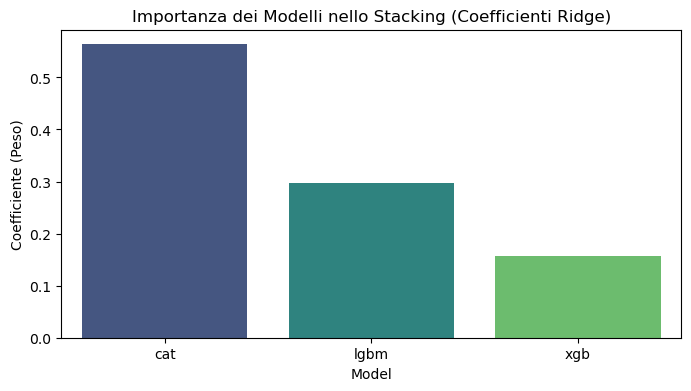


--- Top Features (dal miglior modello base: XGB) ---
RATIO_AveOccup_div_MedInc    0.553213
RATIO_MedInc_div_AveOccup    0.075148
MULT_Dist_SF_x_Dist_LA       0.065411
RATIO_Dist_SF_div_MedInc     0.022239
MULT_MedInc_x_AveBedrms      0.021945
Latitude                     0.021011
Longitude                    0.020107
RATIO_Dist_LA_div_Dist_SF    0.019904
MULT_MedInc_x_HouseAge       0.012793
SQUARE_Dist_LA               0.010028
dtype: float32


In [16]:
import numpy as np
import pandas as pd
import optuna
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset e Preprocessing
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel

# Modelli
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import StackingRegressor

# Visualizzazione Optuna
from optuna.visualization import plot_optimization_history

# Configurazione
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. CARICAMENTO E PULIZIA (IQR)
# ---------------------------------------------------------
print("1. Caricamento e Pulizia Dati...")
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")
df = pd.concat([X, y], axis=1)
df = df[df['MedHouseVal'] < 5.0]

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    indices_to_drop = []
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df_clean[(df_clean[col] < Q1 - 1.5*IQR) | (df_clean[col] > Q3 + 1.5*IQR)].index
        indices_to_drop.extend(outliers)
    return df_clean.drop(list(set(indices_to_drop)))

# Puliamo solo le colonne fisiche soggette a errori
cols_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'MedInc']
df = remove_outliers_iqr(df, cols_clean)
print(f"Dataset pulito: {df.shape}")

# ---------------------------------------------------------
# 2. MANUALE FEATURE ENGINEERING (BRUTE FORCE)
# ---------------------------------------------------------
print("2. Generazione Feature Manuale (Log, Quadrati, Prodotti, Rapporti)...")

def generate_manual_combinations(df_input, cols_to_combine):
    df_eng = df_input.copy()
    
    # Escludiamo Lat/Lon/Cluster dai calcoli matematici puri
    math_cols = [c for c in cols_to_combine if c not in ['Latitude', 'Longitude', 'Geo_Cluster']]
    
    print(f"   -> Elaborazione su {len(math_cols)} colonne base...")

    # A. LOGARITMI (Normalizzazione skewness)
    for col in math_cols:
        if df_eng[col].min() >= 0:
            df_eng[f'LOG_{col}'] = np.log1p(df_eng[col])

    # B. QUADRATI (Non-linearità a U)
    for col in math_cols:
        df_eng[f'SQUARE_{col}'] = df_eng[col] ** 2

    # C. PRODOTTI (Interazioni A * B)
    for col1, col2 in itertools.combinations(math_cols, 2):
        col_name = f'MULT_{col1}_x_{col2}'
        df_eng[col_name] = df_eng[col1] * df_eng[col2]
        
    # D. RAPPORTI (Efficienza A / B)
    for col1, col2 in itertools.permutations(math_cols, 2):
        col_name = f'RATIO_{col1}_div_{col2}'
        df_eng[col_name] = df_eng[col1] / (df_eng[col2] + 1e-5) # Epsilon safety

    return df_eng

# --- Geo Features Base ---
sf_coords = (37.7749, -122.4194)
la_coords = (34.0522, -118.2437)
df['Dist_SF'] = np.sqrt((df['Latitude'] - sf_coords[0])**2 + (df['Longitude'] - sf_coords[1])**2)
df['Dist_LA'] = np.sqrt((df['Latitude'] - la_coords[0])**2 + (df['Longitude'] - la_coords[1])**2)

# KMeans Cluster
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
geo_scaled = StandardScaler().fit_transform(df[['Latitude', 'Longitude']])
df['Geo_Cluster'] = kmeans.fit_predict(geo_scaled)

X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# --- Esecuzione Generazione ---
cols_for_math = [c for c in X.columns if c != 'Geo_Cluster']
X_full = generate_manual_combinations(X, cols_for_math)

# Pulizia post-generazione
X_full.replace([np.inf, -np.inf], np.nan, inplace=True)
X_full.fillna(0, inplace=True)
print(f"   -> Totale Feature create: {X_full.shape[1]}")

# ---------------------------------------------------------
# 3. SELEZIONE FEATURE (LASSO)
# ---------------------------------------------------------
print("3. Selezione Feature Intelligente (Lasso)...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_full)

# LassoCV seleziona automaticamente l'alpha migliore
lasso_selector = SelectFromModel(LassoCV(cv=3, random_state=42, n_jobs=-1, max_iter=2000))
lasso_selector.fit(X_scaled, y)

X_selected = X_full.loc[:, lasso_selector.get_support()]
print(f"   -> Feature Mantenute: {X_selected.shape[1]} (su {X_full.shape[1]})")

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# 4. OPTUNA ROBUSTO (3 MODELLI)
# ---------------------------------------------------------
print("\n4. Tuning Iperparametri Robusto (5-Fold CV interna)...")
kf = KFold(n_splits=3, shuffle=True, random_state=42)
N_TRIALS = 20 # Aumenta a 50+ per produzione

# --- A. XGBoost ---
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5),
        'n_jobs': -1, 'random_state': 42
    }
    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -scores.mean()

print(" -> Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)

# --- B. LightGBM ---
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5),
        'n_jobs': -1, 'verbose': -1, 'random_state': 42
    }
    model = LGBMRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -scores.mean()

print(" -> Optimizing LightGBM...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

# --- C. CatBoost ---
# Nota: CatBoost in CV pura è lento. Riduciamo leggermente lo spazio o i trial.
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'verbose': 0, 'allow_writing_files': False, 'random_state': 42
    }
    model = CatBoostRegressor(**params)
    # CatBoost gestisce il multiprocessing diversamente, n_jobs=-1 in cross_val_score a volte conflict
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=1)
    return -scores.mean()

print(" -> Optimizing CatBoost (potrebbe richiedere tempo)...")
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=10) # Meno trial per CatBoost che è lento

print(f"\nBEST CV RMSE -> XGB: {study_xgb.best_value:.4f} | LGBM: {study_lgbm.best_value:.4f} | CAT: {study_cat.best_value:.4f}")

# ---------------------------------------------------------
# 5. STACKING FINALE
# ---------------------------------------------------------
print("\n5. Stacking Ensemble Finale...")

best_xgb = study_xgb.best_params
best_xgb.update({'n_jobs': -1, 'random_state': 42})

best_lgbm = study_lgbm.best_params
best_lgbm.update({'n_jobs': -1, 'verbose': -1, 'random_state': 42})

best_cat = study_cat.best_params
best_cat.update({'verbose': 0, 'allow_writing_files': False, 'random_state': 42})

estimators = [
    ('xgb', XGBRegressor(**best_xgb)),
    ('lgbm', LGBMRegressor(**best_lgbm)),
    ('cat', CatBoostRegressor(**best_cat))
]

# Il Meta Learner usa le previsioni dei 3 modelli per dare il verdetto finale
stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(), # RidgeCV è robusto alla collinearità tra modelli
    cv=5,
    n_jobs=-1
)

stacking.fit(X_train, y_train)

# ---------------------------------------------------------
# 6. VALUTAZIONE
# ---------------------------------------------------------
y_pred = stacking.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"\n==========================================")
print(f" FINAL TEST SET RESULTS (STACKING)")
print(f"==========================================")
print(f" RMSE: {final_rmse:.5f}")
print(f" R^2 : {final_r2:.5f}")
print(f"==========================================")

# --- 6.1 Analisi dei Coefficienti (Pesi) ---
print("\n--- Analisi Pesi Meta-Learner (RidgeCV) ---")
# Il RidgeCV addestra dei coefficienti per dare un peso a ogni modello base
meta_model = stacking.final_estimator_
model_names = [name for name, _ in stacking.estimators]
coefficients = meta_model.coef_

# Creiamo un DataFrame per visualizzarli bene
weights_df = pd.DataFrame({
    'Model': model_names,
    'Weight': coefficients
}).sort_values(by='Weight', ascending=False)

print(weights_df)
print(f"\nIntercept (Bias): {meta_model.intercept_:.4f}")

# Grafico a Barre dei Pesi
plt.figure(figsize=(8, 4))
sns.barplot(x='Model', y='Weight', data=weights_df, palette='viridis')
plt.title('Importanza dei Modelli nello Stacking (Coefficienti Ridge)')
plt.ylabel('Coefficiente (Peso)')
plt.show()

# --- 6.2 Top Features Assolute ---
print("\n--- Top Features (dal miglior modello base: XGB) ---")
# Recuperiamo XGBoost dall'ensemble addestrato
xgb_fitted = stacking.estimators_[0] 
importances = pd.Series(xgb_fitted.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(10))